In [147]:
import pandas as pd
import numpy as np
import time
import plotly.express as px
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import Image
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [121]:
data=pd.read_csv("../../../../data/stage_1/superdataset.csv")

#Removing statewide unallocated
data = data[data.County_Name != 'statewide unallocated']

data

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
748,1001,autauga county,AL,2020-01-22,0,0,55869
749,1001,autauga county,AL,2020-01-23,0,0,55869
750,1001,autauga county,AL,2020-01-24,0,0,55869
751,1001,autauga county,AL,2020-01-25,0,0,55869
752,1001,autauga county,AL,2020-01-26,0,0,55869
...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,6927
2346472,56045,weston county,WY,2022-02-04,1496,17,6927
2346473,56045,weston county,WY,2022-02-05,1496,17,6927
2346474,56045,weston county,WY,2022-02-06,1496,17,6927


First thing I need to do is pull out my state of choice (Indiana), and find out which 5 counties have the most COVID cases.

In [309]:
#Subset with state I want
indiana=data[data.State=='IN'].reset_index(drop=True)
#Finding counties with highest cases
test=indiana.groupby(["County_Name"])["Confirmed"].max()
test=test.sort_values()
test.tail()

County_Name
st. joseph county     69301
hamilton county       79781
allen county         101761
lake county          104518
marion county        220797
Name: Confirmed, dtype: int64

I then need to pull out those counties into its own dataset. These will be used later. 

In [5]:
#Pulling out above counties
most_cases=indiana[(indiana["County_Name"]=='st. joseph county')|(indiana["County_Name"]=='hamilton county')|
                  (indiana["County_Name"]=='allen county')|(indiana["County_Name"]=='lake county')|
                  (indiana["County_Name"]=='marion county')].reset_index(drop=True)
most_cases

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
0,18003,allen county,IN,2020-01-22,0,0,379299
1,18003,allen county,IN,2020-01-23,0,0,379299
2,18003,allen county,IN,2020-01-24,0,0,379299
3,18003,allen county,IN,2020-01-25,0,0,379299
4,18003,allen county,IN,2020-01-26,0,0,379299
...,...,...,...,...,...,...,...
3735,18141,st. joseph county,IN,2022-02-03,68971,810,271826
3736,18141,st. joseph county,IN,2022-02-04,69076,813,271826
3737,18141,st. joseph county,IN,2022-02-05,69076,813,271826
3738,18141,st. joseph county,IN,2022-02-06,69076,813,271826


Next is calculating new cases and deaths for the state. 

In [310]:
#Getting new cases and deaths
indiana['New_Confirmed']=indiana['Confirmed'].diff()
indiana['New_Deaths']=indiana['Deaths'].diff()

#Fixing NaNs
indiana.New_Confirmed=indiana.New_Confirmed.fillna(0)
indiana.New_Deaths=indiana.New_Deaths.fillna(0)

#Removing unneeded columns
indiana=indiana.drop(columns=["Confirmed","Deaths"])
indiana

,countyFIPS,County_Name,State,Date,population,New_Confirmed,New_Deaths
0,18001,adams county,IN,2020-01-22,35777,0.0,0.0
1,18001,adams county,IN,2020-01-23,35777,0.0,0.0
2,18001,adams county,IN,2020-01-24,35777,0.0,0.0
3,18001,adams county,IN,2020-01-25,35777,0.0,0.0
4,18001,adams county,IN,2020-01-26,35777,0.0,0.0
...,...,...,...,...,...,...,...
68811,18183,whitley county,IN,2022-02-03,33964,26.0,0.0
68812,18183,whitley county,IN,2022-02-04,33964,11.0,0.0
68813,18183,whitley county,IN,2022-02-05,33964,0.0,0.0
68814,18183,whitley county,IN,2022-02-06,33964,0.0,0.0


Since the task calls for days since infection, I'm creating a new column that is a sequence of days starting at the first. Needs to be repeated per county. 

In [311]:
indiana['Days_Infection']=0

#Creating Series with range needed
Days_Infection=pd.Series(range(1,749))

#Using range to repeat days infection
indiana['Days_Infection']=np.tile(Days_Infection,reps=indiana.County_Name.nunique())
indiana

,countyFIPS,County_Name,State,Date,population,New_Confirmed,New_Deaths,Days_Infection
0,18001,adams county,IN,2020-01-22,35777,0.0,0.0,1
1,18001,adams county,IN,2020-01-23,35777,0.0,0.0,2
2,18001,adams county,IN,2020-01-24,35777,0.0,0.0,3
3,18001,adams county,IN,2020-01-25,35777,0.0,0.0,4
4,18001,adams county,IN,2020-01-26,35777,0.0,0.0,5
...,...,...,...,...,...,...,...,...
68811,18183,whitley county,IN,2022-02-03,33964,26.0,0.0,744
68812,18183,whitley county,IN,2022-02-04,33964,11.0,0.0,745
68813,18183,whitley county,IN,2022-02-05,33964,0.0,0.0,746
68814,18183,whitley county,IN,2022-02-06,33964,0.0,0.0,747


This is creating a data frame where New_Confirmed and New_Deaths cannot be less than 0, as there are some aberrant values that don't make sense.

In [312]:
indiana2=indiana[indiana.New_Confirmed>=0]
indiana2=indiana2[indiana2.New_Deaths>=0]
indiana2

,countyFIPS,County_Name,State,Date,population,New_Confirmed,New_Deaths,Days_Infection
0,18001,adams county,IN,2020-01-22,35777,0.0,0.0,1
1,18001,adams county,IN,2020-01-23,35777,0.0,0.0,2
2,18001,adams county,IN,2020-01-24,35777,0.0,0.0,3
3,18001,adams county,IN,2020-01-25,35777,0.0,0.0,4
4,18001,adams county,IN,2020-01-26,35777,0.0,0.0,5
...,...,...,...,...,...,...,...,...
68811,18183,whitley county,IN,2022-02-03,33964,26.0,0.0,744
68812,18183,whitley county,IN,2022-02-04,33964,11.0,0.0,745
68813,18183,whitley county,IN,2022-02-05,33964,0.0,0.0,746
68814,18183,whitley county,IN,2022-02-06,33964,0.0,0.0,747


Finally, we can run linear regression on the data for the state. Let's start with cases. 

In [313]:
fullmodel= smf.ols(formula='New_Confirmed ~ Days_Infection', data=indiana2).fit()
fullmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          New_Confirmed   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1859.
Date:                Sun, 10 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:53:32   Log-Likelihood:            -4.0825e+05
No. Observations:               68535   AIC:                         8.165e+05
Df Residuals:                   68533   BIC:                         8.165e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.6063      0.716     -3.642      0.000      -4.009      -1.204
Days_Infection     0.0714      0.002     43.119      0.000       0.068       0.075
==============================================================================
Omnibus:                   166259.718   Durbin-Watson:                   1.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4479224645.957
Skew:                          25.149   Prob(JB):                         0.00
Kurtosis:                    1254.412   Cond. No.                         866.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that our R^2 value is incredibly low, but the model says that the Days_Infection is significant, as is the F statistic, based on p-value. This could be the result of large sample size impacting the analysis. Days_Infection coefficient is near 0, but is positive, indicating a positive trend. 

We can now graph the model, including a prediction of 7 days ahead. This graph will also include two nonlinear models for comparison.

This graphing code's initial skeleton was based on Lecture 7's Linear Regression plotting code, and modifications were made to fit the data being presented. Please note that the idea to use fill_between for the confidence interval came from this webpage: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python. A function for calculating RMSE was found here: https://www.statsmodels.org/devel/generated/statsmodels.tools.eval_measures.rmse.html

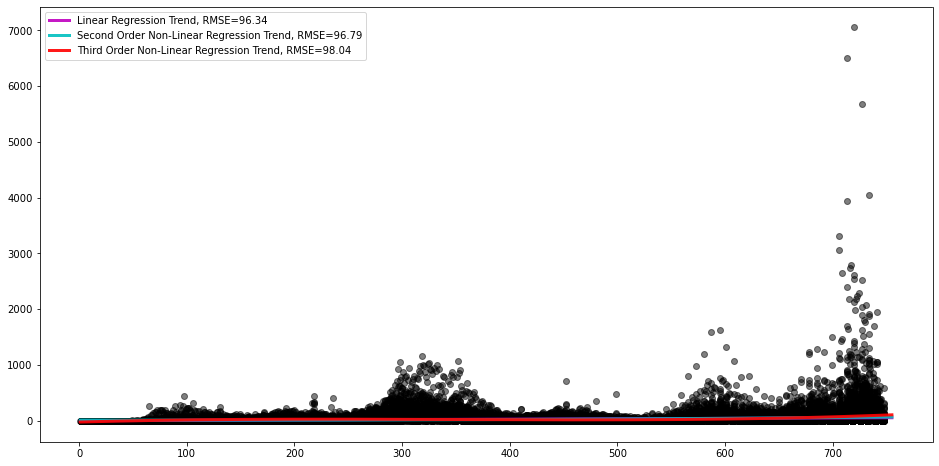

In [314]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(indiana2.Days_Infection, indiana2.New_Confirmed,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(indiana2.Days_Infection.min(), indiana2.Days_Infection.max()+7,num=len(indiana2.index))})

#Creating Confidence Interval
interval=1.96*np.std(fullmodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(indiana2.New_Confirmed, fullmodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, fullmodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(fullmodel.predict(x)-interval), (fullmodel.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0)', data=indiana2).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(indiana2.New_Confirmed, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=indiana2).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(indiana2.New_Confirmed, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

As we can see, the nonlinear models appear to be nearly identical to the linear model based on both the graph and RMSE, so any further analysis likely should stick to the linear model. Interestingly, this differs greatly from graphs you'll see below for the 5 counties we pulled out. I believe it may have to do with some counties underreporting or not reporting cases at all, leading to far lower values than intended, pulling the regression lines down. Let's see if this happens for the deaths.

In [152]:
fullmodel2= smf.ols(formula='New_Deaths ~ Days_Infection', data=indiana2).fit()
fullmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     234.8
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           6.40e-53
Time:                        10:38:17   Log-Likelihood:            -1.2747e+05
No. Observations:               68535   AIC:                         2.550e+05
Df Residuals:                   68533   BIC:                         2.550e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1610      0.012     13.533      0.000       0.138       0.184
Days_Infection     0.0004   2.75e-05     15.325      0.000       0.000       0.000
==============================================================================
Omnibus:                   198810.824   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      31166639374.254
Skew:                          39.673   Prob(JB):                         0.00
Kurtosis:                    3305.700   Cond. No.                         866.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

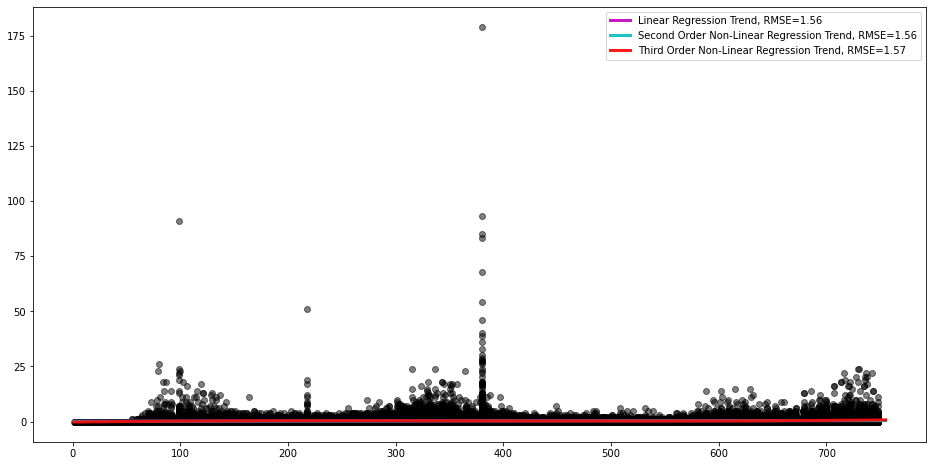

In [159]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(indiana2.Days_Infection, indiana2.New_Deaths,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(indiana2.Days_Infection.min(), indiana2.Days_Infection.max()+7,num=len(indiana2.index))})

#Creating Confidence Interval
interval=1.96*np.std(fullmodel2.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(indiana2.New_Deaths, fullmodel2.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, fullmodel2.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(fullmodel2.predict(x)-interval), (fullmodel2.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0)', data=indiana2).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(indiana2.New_Deaths, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=indiana2).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(indiana2.New_Deaths, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

It's even more pronounced with the deaths, so my previously mentioned theory above apply here as well. Again, the linear model seems to be the best one to use based on the graph and RMSE. 

Let's move on to those five counties, see how they compare. 

In [6]:
#Getting new cases and deaths
most_cases['New_Confirmed']=most_cases['Confirmed'].diff()
most_cases['New_Deaths']=most_cases['Deaths'].diff()

#Fixing NaNs
most_cases.New_Confirmed=most_cases.New_Confirmed.fillna(0)
most_cases.New_Deaths=most_cases.New_Deaths.fillna(0)

#Ensuring data is datetime
data['Date']=pd.to_datetime(data['Date'])

#Removing unneeded columns
most_cases=most_cases.drop(columns=["Confirmed","Deaths"])
most_cases

,countyFIPS,County_Name,State,Date,population,New_Confirmed,New_Deaths
0,18003,allen county,IN,2020-01-22,379299,0.0,0.0
1,18003,allen county,IN,2020-01-23,379299,0.0,0.0
2,18003,allen county,IN,2020-01-24,379299,0.0,0.0
3,18003,allen county,IN,2020-01-25,379299,0.0,0.0
4,18003,allen county,IN,2020-01-26,379299,0.0,0.0
...,...,...,...,...,...,...,...
3735,18141,st. joseph county,IN,2022-02-03,271826,185.0,3.0
3736,18141,st. joseph county,IN,2022-02-04,271826,105.0,3.0
3737,18141,st. joseph county,IN,2022-02-05,271826,0.0,0.0
3738,18141,st. joseph county,IN,2022-02-06,271826,0.0,0.0


In [7]:
most_cases.County_Name.value_counts()

allen county         748
hamilton county      748
lake county          748
marion county        748
st. joseph county    748
Name: County_Name, dtype: int64

In [8]:
most_cases['Days_Infection']=0

#Creating Series with range needed
Days_Infection=pd.Series(range(1,749))

#Using range to repeat days infection
most_cases['Days_Infection']=np.tile(Days_Infection,5)
most_cases

,countyFIPS,County_Name,State,Date,population,New_Confirmed,New_Deaths,Days_Infection
0,18003,allen county,IN,2020-01-22,379299,0.0,0.0,1
1,18003,allen county,IN,2020-01-23,379299,0.0,0.0,2
2,18003,allen county,IN,2020-01-24,379299,0.0,0.0,3
3,18003,allen county,IN,2020-01-25,379299,0.0,0.0,4
4,18003,allen county,IN,2020-01-26,379299,0.0,0.0,5
...,...,...,...,...,...,...,...,...
3735,18141,st. joseph county,IN,2022-02-03,271826,185.0,3.0,744
3736,18141,st. joseph county,IN,2022-02-04,271826,105.0,3.0,745
3737,18141,st. joseph county,IN,2022-02-05,271826,0.0,0.0,746
3738,18141,st. joseph county,IN,2022-02-06,271826,0.0,0.0,747


Now that the data is cleaned up, we need to split by county for graphing purposes. 

In [87]:
allen=most_cases[(most_cases["County_Name"]=='allen county')].reset_index(drop=True)
hamilton=most_cases[(most_cases["County_Name"]=='hamilton county')].reset_index(drop=True)
lake=most_cases[(most_cases["County_Name"]=='lake county')].reset_index(drop=True)
marion=most_cases[(most_cases["County_Name"]=='marion county')].reset_index(drop=True)
st_joseph=most_cases[(most_cases["County_Name"]=='st. joseph county')].reset_index(drop=True)

Let's look at the counties alphabetically. In order to have the trend begin where cases first came in, the following code was used to find the correct index the data should start from.

In [282]:
#Use this to find out the first time cases confirmed
allen.loc[allen['New_Confirmed']>0.0]

,countyFIPS,County_Name,State,Date,population,New_Confirmed,New_Deaths,Days_Infection
58,18003,allen county,IN,2020-03-20,379299,4.0,0.0,59
61,18003,allen county,IN,2020-03-23,379299,2.0,1.0,62
62,18003,allen county,IN,2020-03-24,379299,1.0,0.0,63
64,18003,allen county,IN,2020-03-26,379299,14.0,0.0,65
66,18003,allen county,IN,2020-03-28,379299,2.0,0.0,67
...,...,...,...,...,...,...,...,...
741,18003,allen county,IN,2022-02-01,379299,348.0,5.0,742
742,18003,allen county,IN,2022-02-02,379299,365.0,1.0,743
743,18003,allen county,IN,2022-02-03,379299,259.0,0.0,744
744,18003,allen county,IN,2022-02-04,379299,218.0,0.0,745


In [89]:
allen = allen.iloc[58: , :]
allen

,countyFIPS,County_Name,State,Date,population,New_Confirmed,New_Deaths,Days_Infection
58,18003,allen county,IN,2020-03-20,379299,4.0,0.0,59
59,18003,allen county,IN,2020-03-21,379299,0.0,0.0,60
60,18003,allen county,IN,2020-03-22,379299,0.0,0.0,61
61,18003,allen county,IN,2020-03-23,379299,2.0,1.0,62
62,18003,allen county,IN,2020-03-24,379299,1.0,0.0,63
...,...,...,...,...,...,...,...,...
743,18003,allen county,IN,2022-02-03,379299,259.0,0.0,744
744,18003,allen county,IN,2022-02-04,379299,218.0,0.0,745
745,18003,allen county,IN,2022-02-05,379299,0.0,0.0,746
746,18003,allen county,IN,2022-02-06,379299,0.0,0.0,747


Now we can run our linear model. 

In [90]:
allenmodel= smf.ols(formula='New_Confirmed ~ Days_Infection', data=allen).fit()
allenmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          New_Confirmed   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     105.2
Date:                Sat, 09 Apr 2022   Prob (F-statistic):           4.48e-23
Time:                        15:05:44   Log-Likelihood:                -4758.5
No. Observations:                 690   AIC:                             9521.
Df Residuals:                     688   BIC:                             9530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -42.0695     20.605     -2.042      0.042     -82.525      -1.614
Days_Infection     0.4698      0.046     10.259      0.000       0.380       0.560
==============================================================================
Omnibus:                      646.020   Durbin-Watson:                   1.349
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25812.971
Skew:                           4.152   Prob(JB):                         0.00
Kurtosis:                      31.790   Cond. No.                     1.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Slightly stronger R-squared compared to the state as a whole, and still significant coefficients and F-statistic. How does it look in a graph?

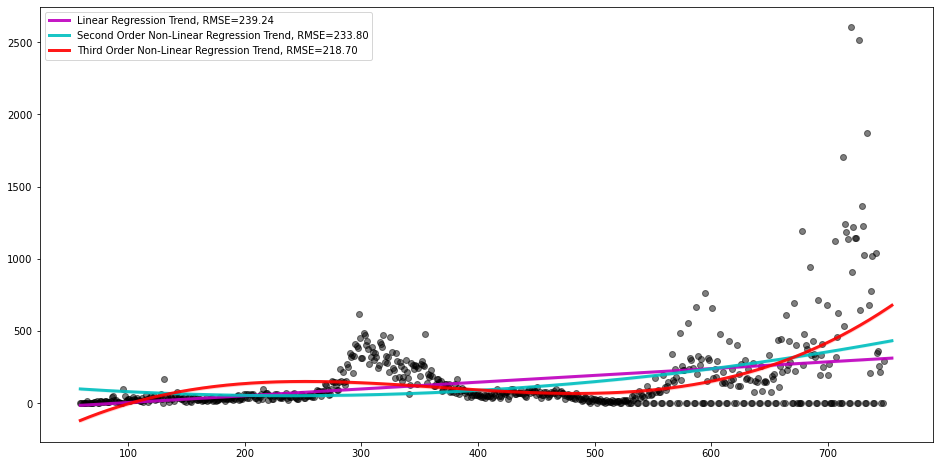

In [158]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(allen.Days_Infection, allen.New_Confirmed,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(allen.Days_Infection.min(), allen.Days_Infection.max()+7,num=len(allen.index))})

#Creating Confidence Interval
interval=1.96*np.std(allenmodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(allen.New_Confirmed, allenmodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, allenmodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(allenmodel.predict(x)-interval), (allenmodel.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0)', data=allen).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(allen.New_Confirmed, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=allen).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(allen.New_Confirmed, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

Now we can see the impact of variance on the nonlinear models. An argrument could be made to use the third order nonlinear model of the linear model, depending on your definition of 'significant decrease in RMSE'. How do deaths look?

In [143]:
rmse1 = rmse(allen.New_Confirmed, allenmodel.predict(x))
rmse1

239.23997680830922

In [92]:
allenmodel2= smf.ols(formula='New_Deaths ~ Days_Infection', data=allen).fit()
allenmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.713
Date:                Sat, 09 Apr 2022   Prob (F-statistic):              0.191
Time:                        15:05:51   Log-Likelihood:                -1722.0
No. Observations:                 690   AIC:                             3448.
Df Residuals:                     688   BIC:                             3457.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.2888      0.253      5.098      0.000       0.792       1.785
Days_Infection     0.0007      0.001      1.309      0.191      -0.000       0.002
==============================================================================
Omnibus:                      750.250   Durbin-Watson:                   1.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51352.075
Skew:                           5.091   Prob(JB):                         0.00
Kurtosis:                      44.018   Cond. No.                     1.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

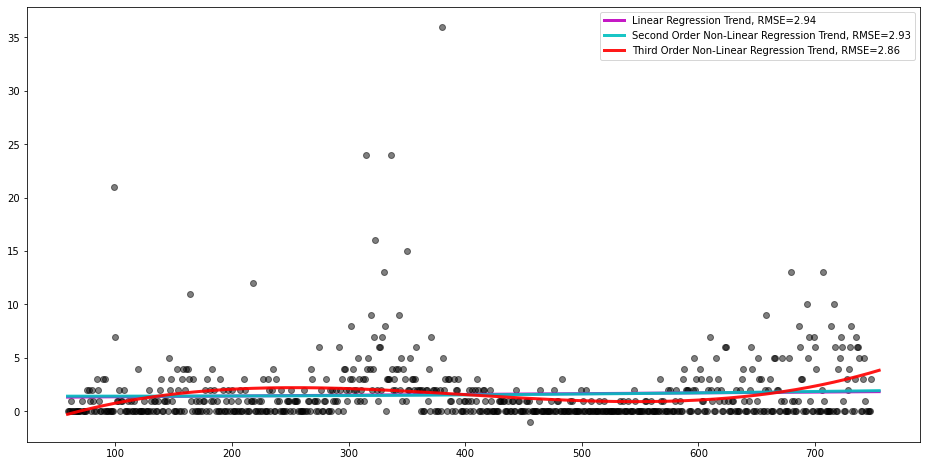

In [157]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(allen.Days_Infection, allen.New_Deaths,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(allen.Days_Infection.min(), allen.Days_Infection.max()+7,num=len(allen.index))})

#Creating Confidence Interval
interval=1.96*np.std(allenmodel2.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(allen.New_Deaths, allenmodel2.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, allenmodel2.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(allenmodel2.predict(x)-interval), (allenmodel2.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0)', data=allen).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(allen.New_Deaths, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=allen).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(allen.New_Deaths, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

It appears only the third order nonlinear model was able to truly become nonlinear, as we can only barely see the linear model next to the second-order nonlinear model. However this is still an improvement over the Indiana deaths graph. 

Next we have Hamilton.

In [94]:
hamilton.loc[hamilton['New_Confirmed']>0.0]
hamilton = hamilton.iloc[52: , :]
hamiltonmodel= smf.ols(formula='New_Confirmed ~ Days_Infection', data=hamilton).fit()
hamiltonmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          New_Confirmed   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     72.36
Date:                Sat, 09 Apr 2022   Prob (F-statistic):           1.10e-16
Time:                        15:05:59   Log-Likelihood:                -4705.4
No. Observations:                 696   AIC:                             9415.
Df Residuals:                     694   BIC:                             9424.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -19.8011     17.680     -1.120      0.263     -54.515      14.913
Days_Infection     0.3357      0.039      8.506      0.000       0.258       0.413
==============================================================================
Omnibus:                      766.063   Durbin-Watson:                   1.384
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52998.110
Skew:                           5.203   Prob(JB):                         0.00
Kurtosis:                      44.464   Cond. No.                         999.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

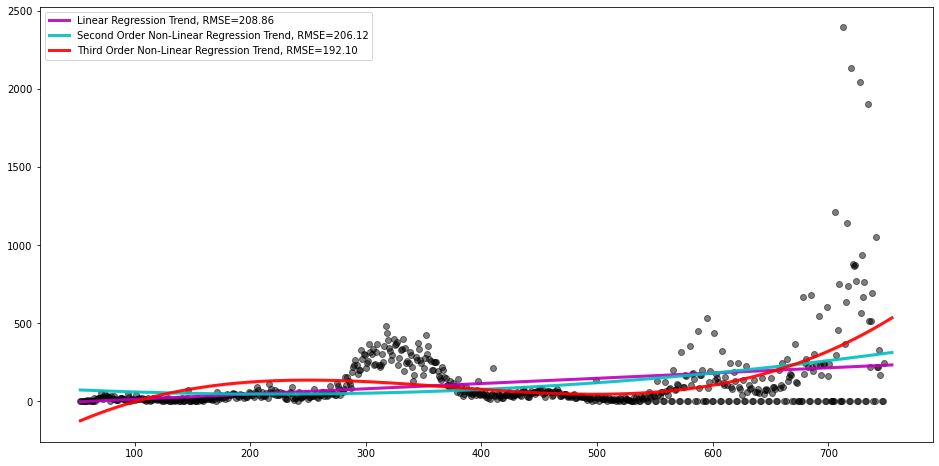

In [163]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(hamilton.Days_Infection, hamilton.New_Confirmed,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(hamilton.Days_Infection.min(), hamilton.Days_Infection.max()+7,num=len(hamilton.index))})

#Creating Confidence Interval
interval=1.96*np.std(hamiltonmodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(hamilton.New_Confirmed, hamiltonmodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, hamiltonmodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(hamiltonmodel.predict(x)-interval), (hamiltonmodel.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0)', data=hamilton).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(hamilton.New_Confirmed, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=hamilton).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(hamilton.New_Confirmed, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

Hamilton is similar to Allen when it comes to cases. Again, an argument could be had for the third-order nonlinear model. And deaths?

In [96]:
hamilton2=hamilton[hamilton.New_Deaths>=0]
hamiltonmodel2= smf.ols(formula='New_Deaths ~ Days_Infection', data=hamilton2).fit()
hamiltonmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.008016
Date:                Sat, 09 Apr 2022   Prob (F-statistic):              0.929
Time:                        15:06:15   Log-Likelihood:                -1538.4
No. Observations:                 692   AIC:                             3081.
Df Residuals:                     690   BIC:                             3090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9039      0.189      4.776      0.000       0.532       1.275
Days_Infection -3.786e-05      0.000     -0.090      0.929      -0.001       0.001
==============================================================================
Omnibus:                     1080.559   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           489347.305
Skew:                           8.948   Prob(JB):                         0.00
Kurtosis:                     132.040   Cond. No.                         995.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

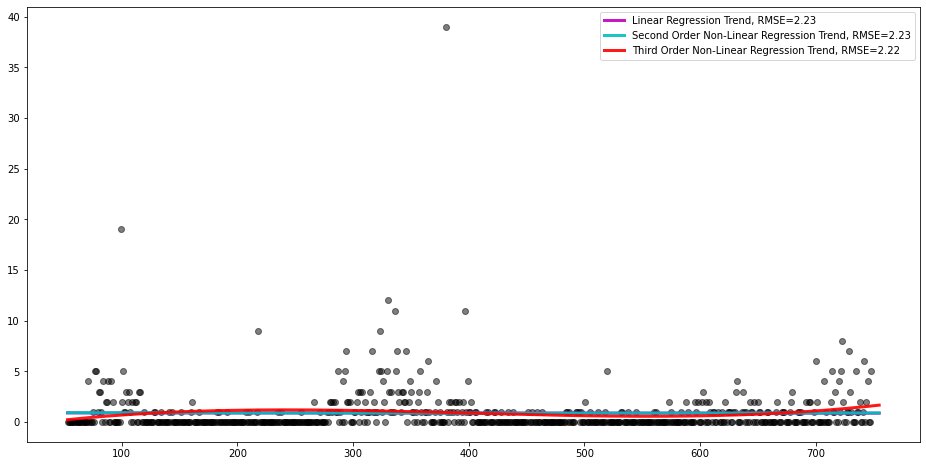

In [166]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(hamilton2.Days_Infection, hamilton2.New_Deaths,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(hamilton.Days_Infection.min(), hamilton2.Days_Infection.max()+7,num=len(hamilton2.index))})

#Creating Confidence Interval
interval=1.96*np.std(hamiltonmodel2.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(hamilton2.New_Deaths, hamiltonmodel2.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, hamiltonmodel2.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(hamiltonmodel2.predict(x)-interval), (hamiltonmodel2.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0)', data=hamilton2).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(hamilton2.New_Deaths, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=hamilton2).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(hamilton2.New_Deaths, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

Hmmm, seems like the non-linear models aren't much different, similar to Indiana as a whole. RMSE is nearly identical for all models. 

Now on to Lake. 

In [168]:
lake.loc[lake['New_Confirmed']>0.0]
lake = lake.iloc[54: , :]
lakemodel= smf.ols(formula='New_Confirmed ~ Days_Infection', data=lake).fit()
lakemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          New_Confirmed   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     35.38
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           4.30e-09
Time:                        11:00:56   Log-Likelihood:                -4860.9
No. Observations:                 694   AIC:                             9726.
Df Residuals:                     692   BIC:                             9735.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         29.8553     22.687      1.316      0.189     -14.687      74.398
Days_Infection     0.3007      0.051      5.948      0.000       0.201       0.400
==============================================================================
Omnibus:                      947.478   Durbin-Watson:                   1.430
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           186636.855
Skew:                           7.173   Prob(JB):                         0.00
Kurtosis:                      82.047   Cond. No.                     1.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

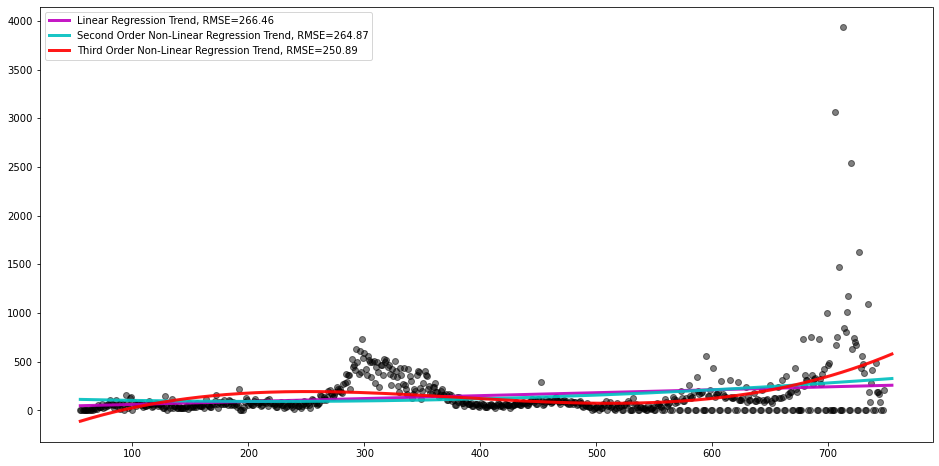

In [169]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(lake.Days_Infection, lake.New_Confirmed,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(lake.Days_Infection.min(), lake.Days_Infection.max()+7,num=len(lake.index))})

#Creating Confidence Interval
interval=1.96*np.std(lakemodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(lake.New_Confirmed, lakemodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, lakemodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(lakemodel.predict(x)-interval), (lakemodel.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0)', data=lake).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(lake.New_Confirmed, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=lake).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(lake.New_Confirmed, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

Again, a similar graph to the other counties, and an argument could be made for the third-order non-linear model, though all trends look to be a tad flatter. On to deaths.

In [170]:
lake2=lake[lake.New_Deaths>=0]
lakemodel2= smf.ols(formula='New_Deaths ~ Days_Infection', data=lake2).fit()
lakemodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     7.799
Date:                Sun, 10 Apr 2022   Prob (F-statistic):            0.00537
Time:                        11:01:12   Log-Likelihood:                -2059.7
No. Observations:                 691   AIC:                             4123.
Df Residuals:                     689   BIC:                             4132.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4579      0.406      3.592      0.000       0.661       2.255
Days_Infection     0.0025      0.001      2.793      0.005       0.001       0.004
==============================================================================
Omnibus:                     1195.019   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1036768.592
Skew:                          10.775   Prob(JB):                         0.00
Kurtosis:                     191.534   Cond. No.                     1.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

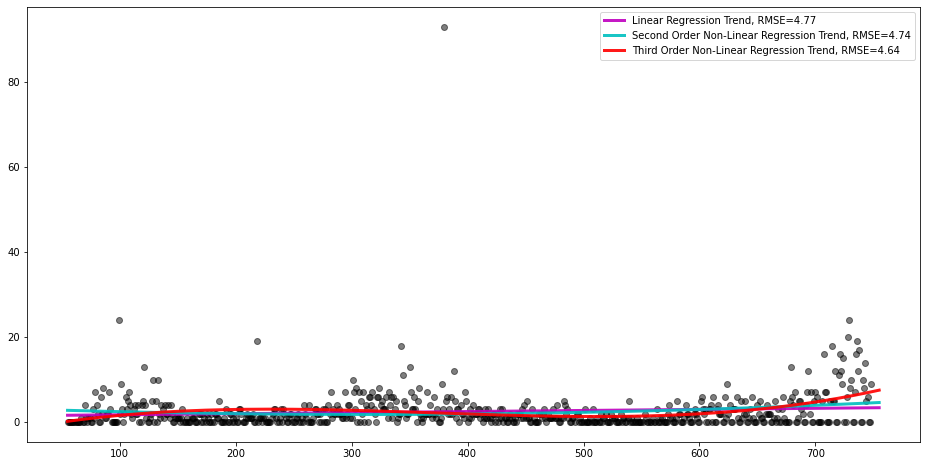

In [171]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(lake2.Days_Infection, lake2.New_Deaths,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(lake2.Days_Infection.min(), lake2.Days_Infection.max()+7,num=len(lake2.index))})

#Creating Confidence Interval
interval=1.96*np.std(lakemodel2.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(lake2.New_Deaths, lakemodel2.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, lakemodel2.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(lakemodel2.predict(x)-interval), (lakemodel2.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0)', data=lake2).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(lake2.New_Deaths, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=lake2).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(lake2.New_Deaths, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

We can actually see linear model clearly without being overshadowed by the second-order nonlinear model in this one, though the differences between the three are still very slight. 

Next we have Marion.

In [172]:
marion.loc[marion['New_Confirmed']>0.0]
marion = marion.iloc[44: , :]
marionmodel= smf.ols(formula='New_Confirmed ~ Days_Infection', data=marion).fit()
marionmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          New_Confirmed   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     61.54
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           1.62e-14
Time:                        11:03:01   Log-Likelihood:                -5457.6
No. Observations:                 704   AIC:                         1.092e+04
Df Residuals:                     702   BIC:                         1.093e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -11.6080     46.588     -0.249      0.803    -103.077      79.861
Days_Infection     0.8203      0.105      7.845      0.000       0.615       1.026
==============================================================================
Omnibus:                      846.979   Durbin-Watson:                   1.392
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            88832.999
Skew:                           5.912   Prob(JB):                         0.00
Kurtosis:                      56.746   Cond. No.                         977.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

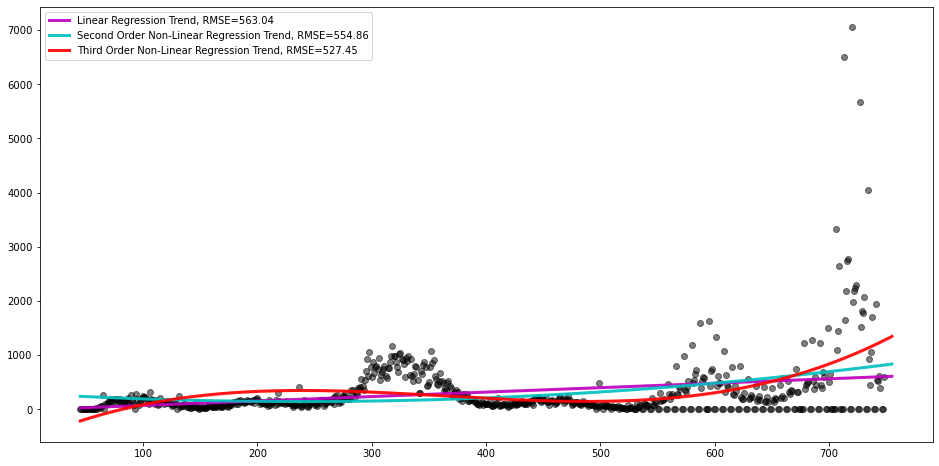

In [173]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(marion.Days_Infection, marion.New_Confirmed,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(marion.Days_Infection.min(), marion.Days_Infection.max()+7,num=len(marion.index))})

#Creating Confidence Interval
interval=1.96*np.std(marionmodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(marion.New_Confirmed, marionmodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, marionmodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(marionmodel.predict(x)-interval), (marionmodel.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0)', data=marion).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(marion.New_Confirmed, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=marion).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(marion.New_Confirmed, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

Same trends for cases that we've seen from the other counties, though not as flat as Lake. Has the biggest decrease in RMSE from linear to third order non-linear. Let's move on to deaths. 

In [112]:
marion2=marion[marion.New_Deaths>=0]
marionmodel2= smf.ols(formula='New_Deaths ~ Days_Infection', data=marion2).fit()
marionmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.529
Date:                Sat, 09 Apr 2022   Prob (F-statistic):              0.217
Time:                        15:14:55   Log-Likelihood:                -2660.9
No. Observations:                 742   AIC:                             5326.
Df Residuals:                     740   BIC:                             5335.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0939      0.642      4.817      0.000       1.833       4.355
Days_Infection     0.0018      0.001      1.237      0.217      -0.001       0.005
==============================================================================
Omnibus:                     1384.486   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1664994.494
Skew:                          12.710   Prob(JB):                         0.00
Kurtosis:                     233.669   Cond. No.                         865.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

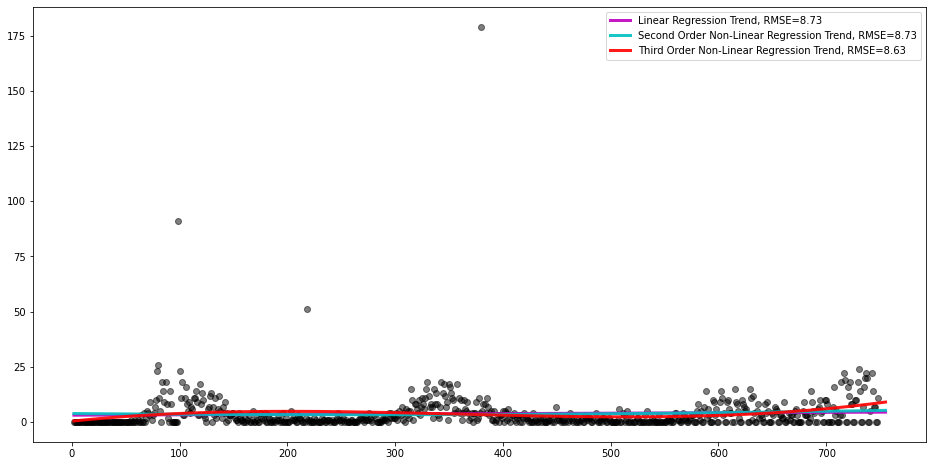

In [174]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(marion2.Days_Infection, marion2.New_Deaths,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(marion2.Days_Infection.min(), marion2.Days_Infection.max()+7,num=len(marion2.index))})

#Creating Confidence Interval
interval=1.96*np.std(marionmodel2.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(marion2.New_Deaths, marionmodel2.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, marionmodel2.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(marionmodel2.predict(x)-interval), (marionmodel2.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0)', data=marion2).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(marion2.New_Deaths, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=marion2).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(marion2.New_Deaths, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

We're back to not really being able to distinguish between the linear and second-order nonlinear models, and linear continues to be the best pick. 

We now go to the final county, St. Joseph.

In [176]:
st_joseph.loc[st_joseph['New_Confirmed']>0.0]
st_joseph = marion.iloc[50: , :]
st_josephmodel= smf.ols(formula='New_Confirmed ~ Days_Infection', data=st_joseph).fit()
st_josephmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          New_Confirmed   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     49.65
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           4.68e-12
Time:                        11:07:24   Log-Likelihood:                -5093.5
No. Observations:                 654   AIC:                         1.019e+04
Df Residuals:                     652   BIC:                         1.020e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -28.9012     55.914     -0.517      0.605    -138.694      80.891
Days_Infection     0.8531      0.121      7.047      0.000       0.615       1.091
==============================================================================
Omnibus:                      769.790   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70759.098
Skew:                           5.691   Prob(JB):                         0.00
Kurtosis:                      52.670   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

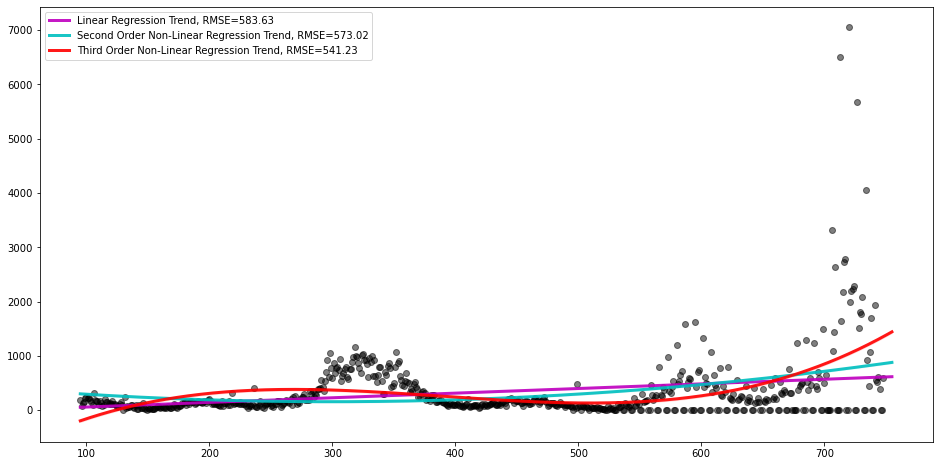

In [177]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(st_joseph.Days_Infection, st_joseph.New_Confirmed,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(st_joseph.Days_Infection.min(), st_joseph.Days_Infection.max()+7,num=len(st_joseph.index))})

#Creating Confidence Interval
interval=1.96*np.std(st_josephmodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(st_joseph.New_Confirmed, st_josephmodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, st_josephmodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(st_josephmodel.predict(x)-interval), (st_josephmodel.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0)', data=st_joseph).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(st_joseph.New_Confirmed, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Confirmed ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=st_joseph).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(st_joseph.New_Confirmed, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

To no one's surprise, cases look the same as they did for the other four counties, and even the RMSE is similar to Marion for the three models. Lastly for deaths:

In [178]:
st_joseph2=st_joseph[st_joseph.New_Deaths>=0]
st_josephmodel2= smf.ols(formula='New_Deaths ~ Days_Infection', data=st_joseph2).fit()
st_josephmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.01400
Date:                Sun, 10 Apr 2022   Prob (F-statistic):              0.906
Time:                        11:07:40   Log-Likelihood:                -2355.8
No. Observations:                 649   AIC:                             4716.
Df Residuals:                     647   BIC:                             4725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.8994      0.875      4.456      0.000       2.181       5.618
Days_Infection     0.0002      0.002      0.118      0.906      -0.003       0.004
==============================================================================
Omnibus:                     1214.123   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1323559.690
Skew:                          12.611   Prob(JB):                         0.00
Kurtosis:                     222.793   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

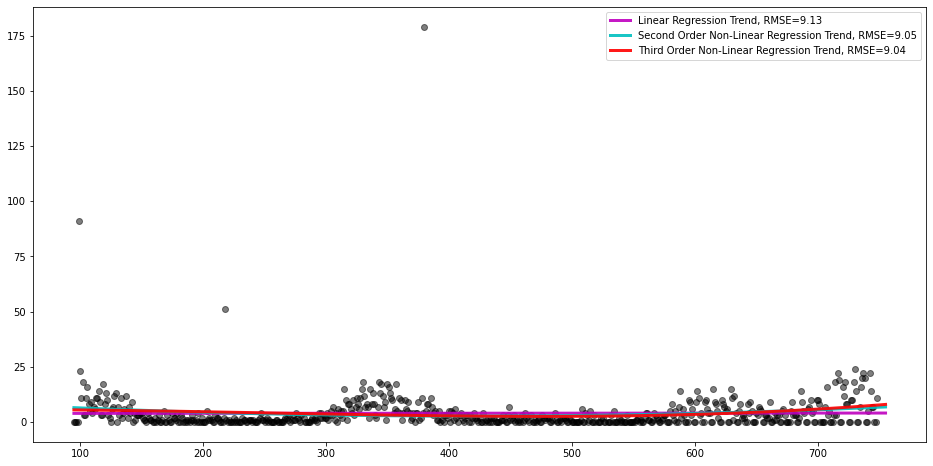

In [179]:
plt.figure(figsize=(16, 8))

#Scatterplot of cases
plt.scatter(st_joseph2.Days_Infection, st_joseph2.New_Deaths,alpha=0.5,c='k')

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(st_joseph2.Days_Infection.min(), st_joseph2.Days_Infection.max()+7,num=len(st_joseph2.index))})

#Creating Confidence Interval
interval=1.96*np.std(st_josephmodel2.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(st_joseph2.New_Deaths, marionmodel2.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, st_josephmodel2.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(st_josephmodel2.predict(x)-interval), (st_josephmodel2.predict(x)+interval), color='m', alpha=.1)

#2nd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_2 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0)', data=st_joseph2).fit()
interval2=1.96*np.std(poly_2.predict(x))/np.sqrt(len(x))
rmse2 = rmse(st_joseph2.New_Deaths, poly_2.predict(x))
plt.plot(x.Days_Infection, poly_2.predict(x), 'c-', label='Second Order Non-Linear Regression Trend, RMSE=%.2f'%rmse2, alpha=0.9,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_2.predict(x)-interval2), (poly_2.predict(x)+interval2), color='c', alpha=.1)

#3rd order Non-Linear Regression trendline overlayed onto the scatterplot
poly_3 = smf.ols(formula='New_Deaths ~ Days_Infection + I(Days_Infection ** 2.0) + I(Days_Infection ** 3.0)', data=st_joseph2).fit()
interval3=1.96*np.std(poly_3.predict(x))/np.sqrt(len(x))
rmse3 = rmse(st_joseph2.New_Deaths, poly_3.predict(x))
plt.plot(x.Days_Infection, poly_3.predict(x), 'r-', alpha=0.9, label='Third Order Non-Linear Regression Trend, RMSE=%.2f'%rmse3,linewidth=3)
plt.fill_between(x.Days_Infection,(poly_3.predict(x)-interval3), (poly_3.predict(x)+interval3), color='r', alpha=.1)

plt.legend()

Interestingly, the second-order nonlinear model here is instead being overshadowed by third-order, instead of overshadowing the linear model. Other than that, the same trends as we've been seeing in the other counties.

The next stage of the project is to look at hospital bed occupancy, and compare that to COVID numbers, to see if we hit a point of no return. COVID cases are a point indicator for this, as the majority of people who get COVID do not need to go to the hospital. Instead we'll use COVID deaths, though one could argue this is also not a great predictor. We will be comparing the deaths in our linear model to a threshold based on the number of ICU beds available in a state. We first need to pull in our data:

In [186]:
beds=pd.read_csv("COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State.csv")
beds=beds[['state','staffed_adult_icu_bed_occupancy']]
beds

,state,staffed_adult_icu_bed_occupancy
0,OR,573
1,PA,2573
2,PR,459
3,RI,113
4,SC,882
5,SD,133
6,TN,1460
7,TX,5348
8,UT,326
9,VA,1242


We're gonna need the values for the beds for Indiana, so we'll save that as an array. We'll do the same for a few more states for future analysis.

In [215]:
indiana_beds=beds.staffed_adult_icu_bed_occupancy.iloc[[42]].values
illinois_beds=beds.staffed_adult_icu_bed_occupancy.iloc[[41]].values
michigan_beds=beds.staffed_adult_icu_bed_occupancy.iloc[[49]].values
kentucky_beds=beds.staffed_adult_icu_bed_occupancy.iloc[[44]].values
wisconsin_beds=beds.staffed_adult_icu_bed_occupancy.iloc[[51]].values
indiana_beds

array([1399], dtype=int64)

Please note that the idea to use axhline for beds came from https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib

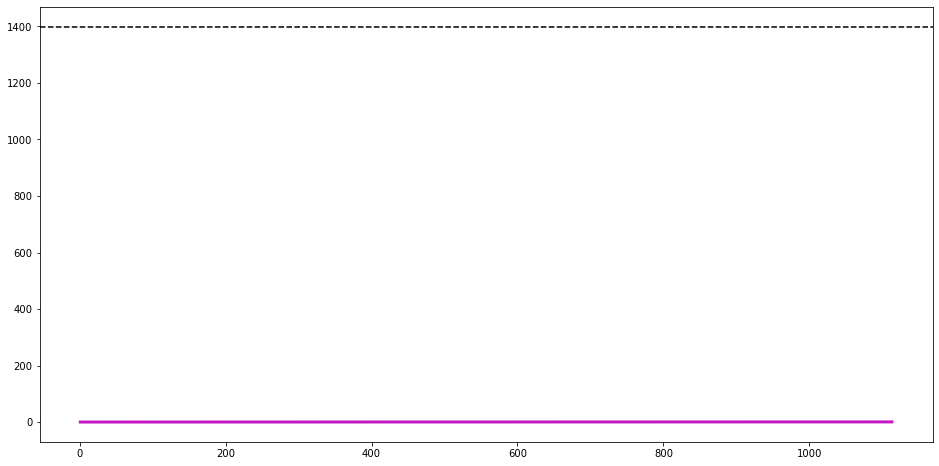

In [204]:
plt.figure(figsize=(16, 8))

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(indiana2.Days_Infection.min(), indiana2.Days_Infection.max()+365,num=len(indiana2.index))})

#Creating Confidence Interval
interval=1.96*np.std(fullmodel2.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(indiana2.New_Deaths, fullmodel2.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, fullmodel2.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(fullmodel2.predict(x)-interval), (fullmodel2.predict(x)+interval), color='m', alpha=.1)

plt.axhline(y=indiana_beds, color='k', linestyle='--')

As we can see, even when just looking at ICU beds, the regression line for COVID deaths for Indiana gets nowhere near the threshold, even when increasing the prediction for a whole year. So, instead of graphing it, let's try solving for it. To start, here's a reminder on Indiana regression model statistics:

In [206]:
fullmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     234.8
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           6.40e-53
Time:                        12:14:16   Log-Likelihood:            -1.2747e+05
No. Observations:               68535   AIC:                         2.550e+05
Df Residuals:                   68533   BIC:                         2.550e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1610      0.012     13.533      0.000       0.138       0.184
Days_Infection     0.0004   2.75e-05     15.325      0.000       0.000       0.000
==============================================================================
Omnibus:                   198810.824   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      31166639374.254
Skew:                          39.673   Prob(JB):                         0.00
Kurtosis:                    3305.700   Cond. No.                         866.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have the coefficients, we can calculate the number of days from infection we predict will hit the point of no return using the regression model equation, but solving for x instead of y. 

In [223]:
x1=(indiana_beds-0.1610)/0.0004
x1/365

array([9581.0890411])

So apparently it will take approximately 9581 years to hit the point of no return. What about if we look at other states? We of course need to generate the model first. The code for that is the same as we did for Indiana, so it will be all in one code block.

Illinois:

In [214]:
illinois=data[data.State=='IL'].reset_index(drop=True)
#Getting new cases and deaths
illinois['New_Confirmed']=illinois['Confirmed'].diff()
illinois['New_Deaths']=illinois['Deaths'].diff()

#Fixing NaNs
illinois.New_Confirmed=illinois.New_Confirmed.fillna(0)
illinois.New_Deaths=illinois.New_Deaths.fillna(0)

#Removing unneeded columns
illinois=illinois.drop(columns=["Confirmed","Deaths"])

illinois['Days_Infection']=0
illinois['Days_Infection']=np.tile(Days_Infection,reps=illinois.County_Name.nunique())

illinois2=illinois[illinois.New_Confirmed>=0]
illinois2=illinois2[illinois2.New_Deaths>=0]
illinoismodel= smf.ols(formula='New_Deaths ~ Days_Infection', data=illinois2).fit()
illinoismodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1482
Date:                Sun, 10 Apr 2022   Prob (F-statistic):              0.700
Time:                        12:30:53   Log-Likelihood:            -2.0350e+05
No. Observations:               74927   AIC:                         4.070e+05
Df Residuals:                   74925   BIC:                         4.070e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4775      0.027     17.815      0.000       0.425       0.530
Days_Infection  -2.38e-05   6.18e-05     -0.385      0.700      -0.000    9.74e-05
==============================================================================
Omnibus:                   234966.101   Durbin-Watson:                   0.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      87053319952.980
Skew:                          49.100   Prob(JB):                         0.00
Kurtosis:                    5282.636   Cond. No.                         869.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

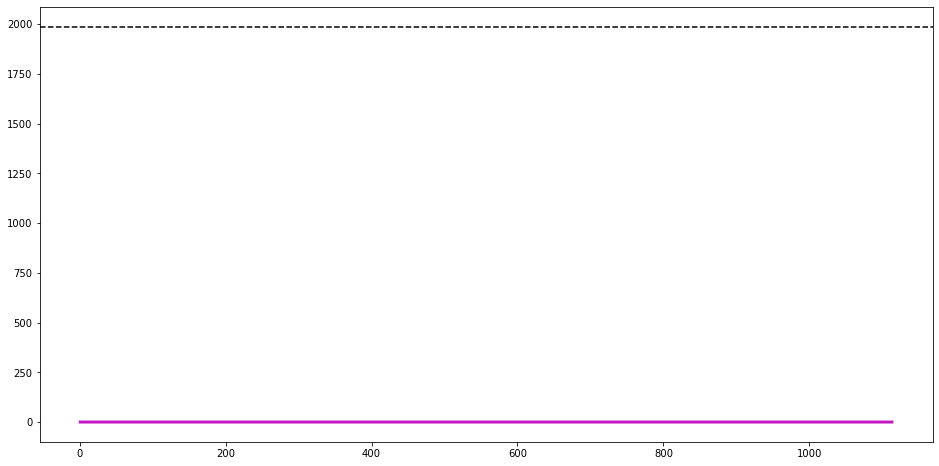

In [216]:
plt.figure(figsize=(16, 8))


#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(illinois2.Days_Infection.min(), illinois2.Days_Infection.max()+365,num=len(illinois2.index))})

#Creating Confidence Interval
interval=1.96*np.std(illinoismodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(illinois2.New_Deaths, illinoismodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, illinoismodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(illinoismodel.predict(x)-interval), (illinoismodel.predict(x)+interval), color='m', alpha=.1)

plt.axhline(y=illinois_beds, color='k', linestyle='--')

Not surprisingly, we see a similar trend to Indiana with Illinois. Normally I'd move on to calculating the point of no return, but that's not required here. The coefficient for Days_Infection is negative, meaning there's a downward trend. As such, the current prediction has no point of no return.

Michigan:

In [219]:
michigan=data[data.State=='MI'].reset_index(drop=True)
#Getting new cases and deaths
michigan['New_Confirmed']=michigan['Confirmed'].diff()
michigan['New_Deaths']=michigan['Deaths'].diff()

#Fixing NaNs
michigan.New_Confirmed=michigan.New_Confirmed.fillna(0)
michigan.New_Deaths=michigan.New_Deaths.fillna(0)

#Removing unneeded columns
michigan=michigan.drop(columns=["Confirmed","Deaths"])

michigan['Days_Infection']=0
michigan['Days_Infection']=np.tile(Days_Infection,reps=michigan.County_Name.nunique())

michigan2=michigan[michigan.New_Confirmed>=0]
michigan2=michigan2[michigan2.New_Deaths>=0]
michiganmodel= smf.ols(formula='New_Deaths ~ Days_Infection', data=michigan2).fit()
michiganmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     140.1
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           2.78e-32
Time:                        12:43:14   Log-Likelihood:            -1.5462e+05
No. Observations:               61653   AIC:                         3.092e+05
Df Residuals:                   61651   BIC:                         3.093e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2885      0.024     12.045      0.000       0.242       0.335
Days_Infection     0.0007   5.54e-05     11.835      0.000       0.001       0.001
==============================================================================
Omnibus:                   127116.096   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        573790901.653
Skew:                          17.481   Prob(JB):                         0.00
Kurtosis:                     474.318   Cond. No.                         865.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

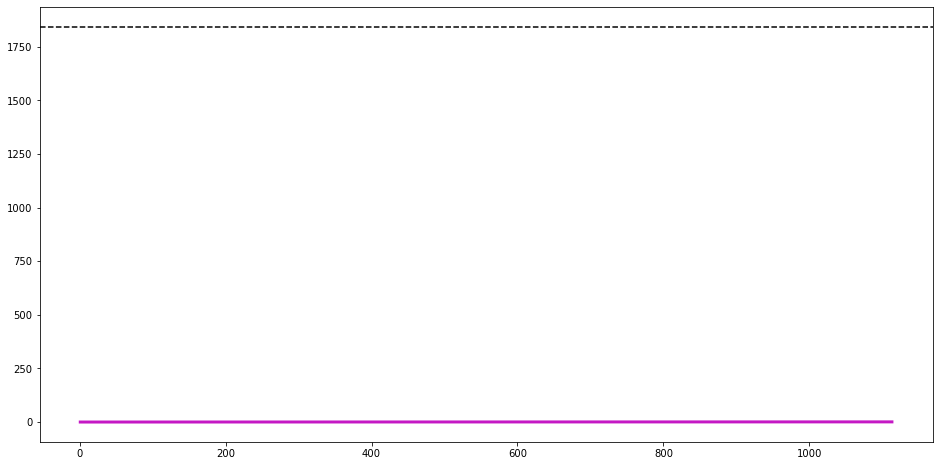

In [220]:
plt.figure(figsize=(16, 8))

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(michigan2.Days_Infection.min(), michigan2.Days_Infection.max()+365,num=len(michigan2.index))})

#Creating Confidence Interval
interval=1.96*np.std(michiganmodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(michigan2.New_Deaths, michiganmodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, michiganmodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(michiganmodel.predict(x)-interval), (michiganmodel.predict(x)+interval), color='m', alpha=.1)

plt.axhline(y=michigan_beds, color='k', linestyle='--')

Still not hitting the threshold, but we can calculate the point of no return for this one:

In [224]:
x1=(michigan_beds-0.1610)/0.0004
x1/365

array([12622.18493151])

12622 years for Michigan, it seems.

Kentucky:

In [225]:
kentucky=data[data.State=='KY'].reset_index(drop=True)
#Getting new cases and deaths
kentucky['New_Confirmed']=kentucky['Confirmed'].diff()
kentucky['New_Deaths']=kentucky['Deaths'].diff()

#Fixing NaNs
kentucky.New_Confirmed=kentucky.New_Confirmed.fillna(0)
kentucky.New_Deaths=kentucky.New_Deaths.fillna(0)

#Removing unneeded columns
kentucky=kentucky.drop(columns=["Confirmed","Deaths"])

kentucky['Days_Infection']=0
kentucky['Days_Infection']=np.tile(Days_Infection,reps=kentucky.County_Name.nunique())

kentucky2=kentucky[kentucky.New_Confirmed>=0]
kentucky2=kentucky2[kentucky2.New_Deaths>=0]
kentuckymodel= smf.ols(formula='New_Deaths ~ Days_Infection', data=kentucky2).fit()
kentuckymodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     798.1
Date:                Sun, 10 Apr 2022   Prob (F-statistic):          8.53e-175
Time:                        12:49:02   Log-Likelihood:            -1.0955e+05
No. Observations:               88915   AIC:                         2.191e+05
Df Residuals:                   88913   BIC:                         2.191e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0114      0.006      2.050      0.040       0.001       0.022
Days_Infection     0.0004   1.29e-05     28.250      0.000       0.000       0.000
==============================================================================
Omnibus:                   279300.786   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     112741918602.427
Skew:                          49.304   Prob(JB):                         0.00
Kurtosis:                    5518.583   Cond. No.                         863.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

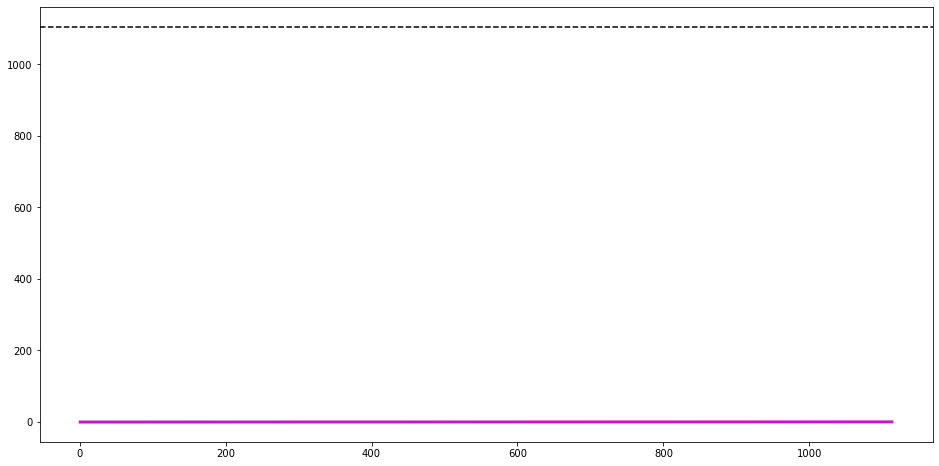

In [226]:
plt.figure(figsize=(16, 8))

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(kentucky2.Days_Infection.min(), kentucky2.Days_Infection.max()+365,num=len(kentucky2.index))})

#Creating Confidence Interval
interval=1.96*np.std(kentuckymodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(kentucky2.New_Deaths, kentuckymodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, kentuckymodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(kentuckymodel.predict(x)-interval), (kentuckymodel.predict(x)+interval), color='m', alpha=.1)

plt.axhline(y=kentucky_beds, color='k', linestyle='--')

Same as before, not hitting the threshold. Now for the calculation:

In [227]:
x1=(kentucky_beds-0.1610)/0.0004
x1/365

array([7567.39041096])

Well, Kentucky has been the closest so far, relatively speaking, at 7567 years. Lastly we have Wisconsin.

Wisconsin:

In [228]:
wisconsin=data[data.State=='WI'].reset_index(drop=True)
#Getting new cases and deaths
wisconsin['New_Confirmed']=wisconsin['Confirmed'].diff()
wisconsin['New_Deaths']=wisconsin['Deaths'].diff()

#Fixing NaNs
wisconsin.New_Confirmed=wisconsin.New_Confirmed.fillna(0)
wisconsin.New_Deaths=wisconsin.New_Deaths.fillna(0)

#Removing unneeded columns
wisconsin=wisconsin.drop(columns=["Confirmed","Deaths"])

wisconsin['Days_Infection']=0
wisconsin['Days_Infection']=np.tile(Days_Infection,reps=wisconsin.County_Name.nunique())

wisconsin2=wisconsin[wisconsin.New_Confirmed>=0]
wisconsin2=wisconsin2[wisconsin2.New_Deaths>=0]
wisconsinmodel= smf.ols(formula='New_Deaths ~ Days_Infection', data=wisconsin2).fit()
wisconsinmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             New_Deaths   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     254.0
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           4.83e-57
Time:                        12:52:42   Log-Likelihood:                -70984.
No. Observations:               53619   AIC:                         1.420e+05
Df Residuals:                   53617   BIC:                         1.420e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1277      0.008     16.221      0.000       0.112       0.143
Days_Infection     0.0003   1.82e-05     15.936      0.000       0.000       0.000
==============================================================================
Omnibus:                    91072.277   Durbin-Watson:                   1.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        218807714.928
Skew:                          11.343   Prob(JB):                         0.00
Kurtosis:                     315.129   Cond. No.                         865.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

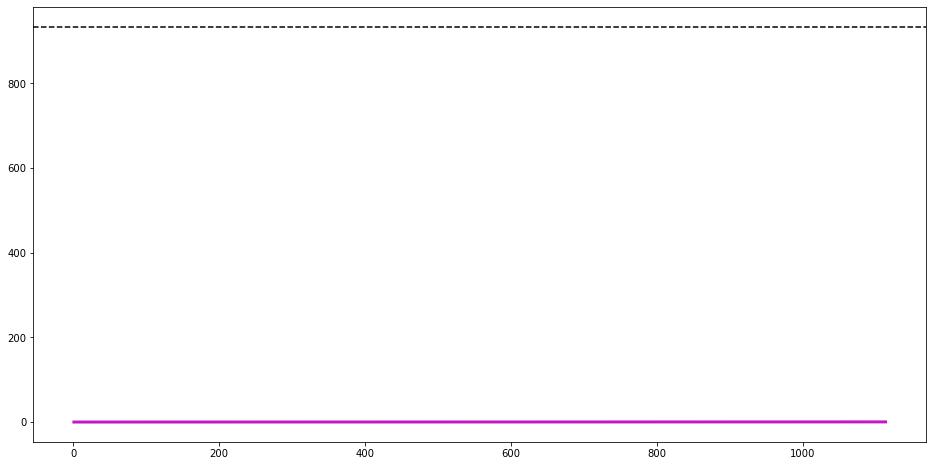

In [229]:
plt.figure(figsize=(16, 8))

#Creating Dataframe that allows us to predict one week ahead
x = pd.DataFrame({'Days_Infection': np.linspace(wisconsin2.Days_Infection.min(), wisconsin2.Days_Infection.max()+365,num=len(wisconsin2.index))})

#Creating Confidence Interval
interval=1.96*np.std(wisconsinmodel.predict(x))/np.sqrt(len(x))

#Generating RMSE
rmse1 = rmse(wisconsin2.New_Deaths, wisconsinmodel.predict(x))

#Linear Regression trendline overlayed onto the scatterplot
plt.plot(x.Days_Infection, wisconsinmodel.predict(x), 'm-', label='Linear Regression Trend, RMSE=%.2f'%rmse1,alpha=0.9,linewidth=3)

#Using confidence interval to fill in around the line
plt.fill_between(x.Days_Infection,(wisconsinmodel.predict(x)-interval), (wisconsinmodel.predict(x)+interval), color='m', alpha=.1)

plt.axhline(y=wisconsin_beds, color='k', linestyle='--')

The same trend we've been seeing persists. So how about the calculation?

In [230]:
x1=(wisconsin_beds-0.1610)/0.0004
x1/365

array([6396.15753425])

So it seems that Wisconsin will hit the point of no return first...eventually. 

The last step of the member task is to conduct some hypthesis tests. Any code used below to clean and merge the data to have enrichment data alongside normalized COVID cases and deaths per state is based on code I ran in my Stage 3 member task, with modifications made as needed. As a reminder, these were the three hypotheses:

Hypothesis 1: Does an increase in foreign born residents lead to higher counts of COVID cases or deaths?

Hypothesis 2: Does having a higher number of residents with no diploma lead to higher counts of COVID cases or deaths?

Hypothesis 2: Does having a higher number of residents with a Bachelor's degree lead to higher counts of COVID cases or deaths?

Bringing back in the Enrichment data:

In [231]:
enrichment=pd.read_csv("../../../../data/stage_1/ACS_Economic_Social_Merged.csv")
enrichment.head()

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,No_Diploma,High_School,Associates,...,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level
0,1003,baldwin county,AL,1/22/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1
1,1003,baldwin county,AL,1/23/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1
2,1003,baldwin county,AL,1/24/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1
3,1003,baldwin county,AL,1/25/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1
4,1003,baldwin county,AL,1/26/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1


In [244]:
state_pop=enrichment[['County_Name','State','population']]
#Removing duplicates due to dates, since population doesn't change based on date
state_pop=state_pop.drop_duplicates(subset=['County_Name'])
state_pop=state_pop.groupby("State").agg("sum")
#Getting just the states we need
needed_pop=state_pop[state_pop.index.isin(['IN','IL','MI','WI','KY'])]
needed_pop

,population
State,
IL,9509270
IN,3044333
KY,890301
MI,5414389
WI,3905965


In [243]:
#Removing duplicates
clean_enrich=enrichment.drop_duplicates(subset=['countyFIPS'])
#Dropping unneeded columns
clean_enrich=clean_enrich.drop(["Date",'Confirmed','Deaths','countyFIPS','County_Name','population'],axis=1)
#Aggregating by mean instead of sum
clean_enrich=clean_enrich.groupby("State").agg("mean").round(2)
#Getting just the states we need
needed_enrich=clean_enrich[clean_enrich.index.isin(['IN','IL','MI','WI','KY'])]
needed_enrich

,No_Diploma,High_School,Associates,Bachelors,Graduate,Foreign_Born,Less_TenK,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level
State,,,,,,,,,,,,,,,,,
IL,17790.87,78929.48,24956.83,74823.78,49369.87,75115.52,10642.57,6173.61,13657.74,13750.91,19613.00,28945.35,23006.43,31204.22,15037.70,18028.13,11.86
IN,8082.96,38955.04,10757.92,24291.35,14008.85,12267.35,4623.73,2829.27,6714.69,6889.38,9844.58,13743.08,9033.31,10844.27,4228.62,3874.73,12.36
KY,6529.00,31123.54,9965.08,23330.31,15351.46,12234.62,4111.46,2745.46,6332.46,6223.85,8741.62,12756.92,8744.69,9944.54,3896.62,3766.54,12.87
MI,11593.93,55680.45,18583.83,38749.72,25712.31,23261.48,7128.41,4535.66,9975.79,11013.14,14895.86,21136.41,15320.86,17447.00,7377.55,7258.83,12.30
WI,6162.87,37487.30,13820.74,29533.65,15543.83,11488.09,3465.30,3032.91,6388.43,6582.57,10161.61,14565.35,10898.26,13568.22,5246.52,4513.91,9.20


In [245]:
enrich_with_pop=pd.merge(needed_enrich,needed_pop, on='State')
#Normalizing
enrich_with_pop=enrich_with_pop.div(enrich_with_pop.population,axis=0)*100000
enrich_with_pop

,No_Diploma,High_School,Associates,Bachelors,Graduate,Foreign_Born,Less_TenK,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level,population
State,,,,,,,,,,,,,,,,,,
IL,187.089756,830.026700,262.447380,786.850936,519.176235,789.918890,111.917844,64.922018,143.625536,144.605317,206.251374,304.390873,241.936868,328.145273,158.137270,189.584795,0.124720,100000.0
IN,265.508405,1279.591950,353.375271,797.920267,460.161553,402.956904,151.879903,92.935628,220.563585,226.301788,323.373954,451.431562,296.725424,356.211689,138.901362,127.276812,0.406000,100000.0
KY,733.347486,3495.844664,1119.293363,2620.496888,1724.299984,1374.211643,461.805614,308.374359,711.271806,699.072561,981.872423,1432.877195,982.217250,1116.986278,437.674449,423.063660,1.445579,100000.0
MI,214.131825,1028.379195,343.230418,715.680384,474.888487,429.623361,131.656776,83.770486,184.245905,203.405038,275.116177,390.374796,282.965631,322.233958,136.258219,134.065543,0.227172,100000.0
WI,157.780984,959.744903,353.836760,756.116606,397.951083,294.116563,88.718153,77.648161,163.555741,168.526088,260.156197,372.900167,279.015813,347.371776,134.320712,115.564528,0.235537,100000.0


Now we need the weekly normalized data for cases and deaths for Indiana, Illinois, Michginan, Kentucky, and Wisconsin. This code also was pulled from the Stage 3 member task I wrote.

In [242]:
#Summing unique population values
indiana_pop=indiana2.population.drop_duplicates().sum()

indiana_agg=indiana2.drop(columns=['countyFIPS','County_Name','population','Days_Infection'])
#Aggregating to state level
indiana_agg=indiana_agg.groupby('Date').agg('sum')
indiana_agg=indiana_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])

indiana_weekly_avg = indiana_agg
indiana_weekly_avg.reset_index(inplace=True)

#Using resample to aggregate daily to weekly
indiana_weekly_avg = indiana_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
indiana_weekly_avg.New_Confirmed = indiana_weekly_avg.New_Confirmed.round()
indiana_weekly_avg.New_Deaths = indiana_weekly_avg.New_Deaths.round()
indiana_weekly_avg['New_Confirmed_per_100000'] = indiana_weekly_avg.New_Confirmed/indiana_pop *100000
indiana_weekly_avg['New_Deaths_per_100000'] = indiana_weekly_avg.New_Deaths/indiana_pop *100000

#Reintroducing State
indiana_confirmed=indiana_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
indiana_confirmed[["State"]]="Indiana"
indiana_confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
Date,,,
2020-01-26,0.000000,0.000000,Indiana
2020-02-02,0.000000,0.000000,Indiana
2020-02-09,0.000000,0.000000,Indiana
2020-02-16,0.000000,0.000000,Indiana
2020-02-23,0.000000,0.000000,Indiana
...,...,...,...
2022-01-09,204.865587,1.292293,Indiana
2022-01-16,209.425748,1.114046,Indiana
2022-01-23,168.785359,1.173462,Indiana


In [247]:
illinois2['Date']=pd.to_datetime(illinois2['Date'])

#Summing unique population values
illinois_pop=illinois2.population.drop_duplicates().sum()

illinois_agg=illinois2.drop(columns=['countyFIPS','County_Name','population','Days_Infection'])
#Aggregating to state level
illinois_agg=illinois_agg.groupby('Date').agg('sum')
illinois_agg=illinois_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])

illinois_weekly_avg=illinois_agg
illinois_weekly_avg.reset_index(inplace=True)

#Using resample to aggregate daily to weekly
illinois_weekly_avg=illinois_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
illinois_weekly_avg.New_Confirmed = illinois_weekly_avg.New_Confirmed.round()
illinois_weekly_avg.New_Deaths = illinois_weekly_avg.New_Deaths.round()
illinois_weekly_avg['New_Confirmed_per_100000'] = illinois_weekly_avg.New_Confirmed/illinois_pop *100000
illinois_weekly_avg['New_Deaths_per_100000'] = illinois_weekly_avg.New_Deaths/illinois_pop *100000

#Reintroducing State
illinois_confirmed=illinois_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
illinois_confirmed[["State"]]="Illinois"
illinois_confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
Date,,,
2020-01-26,0.000000,0.000000,Illinois
2020-02-02,0.000000,0.000000,Illinois
2020-02-09,0.000000,0.000000,Illinois
2020-02-16,0.000000,0.000000,Illinois
2020-02-23,0.000000,0.000000,Illinois
...,...,...,...
2022-01-09,236.532697,0.844393,Illinois
2022-01-16,217.443097,0.868068,Illinois
2022-01-23,104.452233,0.946983,Illinois


In [248]:
michigan2['Date']=pd.to_datetime(michigan2['Date'])

#Summing unique population values in Indiana
michigan_pop=michigan2.population.drop_duplicates().sum()

michigan_agg=michigan2.drop(columns=['countyFIPS','County_Name','population','Days_Infection'])
#Aggregating to state level
michigan_agg=michigan_agg.groupby('Date').agg('sum')
michigan_agg=michigan_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])

michigan_weekly_avg=michigan_agg
michigan_weekly_avg.reset_index(inplace=True)

#Using resample to aggregate daily to weekly
michigan_weekly_avg=michigan_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
michigan_weekly_avg.New_Confirmed = michigan_weekly_avg.New_Confirmed.round()
michigan_weekly_avg.New_Deaths = michigan_weekly_avg.New_Deaths.round()
michigan_weekly_avg['New_Confirmed_per_100000'] = michigan_weekly_avg.New_Confirmed/michigan_pop *100000
michigan_weekly_avg['New_Deaths_per_100000'] = michigan_weekly_avg.New_Deaths/michigan_pop *100000

#Reintroducing State
michigan_confirmed=michigan_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
michigan_confirmed[["State"]]="Michigan"
michigan_confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
Date,,,
2020-01-26,0.000000,0.000000,Michigan
2020-02-02,0.000000,0.000000,Michigan
2020-02-09,0.000000,0.000000,Michigan
2020-02-16,0.000000,0.000000,Michigan
2020-02-23,0.000000,0.000000,Michigan
...,...,...,...
2022-01-09,181.108030,1.081421,Michigan
2022-01-16,196.958863,1.131487,Michigan
2022-01-23,152.510444,0.991303,Michigan


In [249]:
kentucky2['Date']=pd.to_datetime(kentucky2['Date'])

#Summing unique population values in Indiana
kentucky_pop=kentucky2.population.drop_duplicates().sum()

kentucky_agg=kentucky2.drop(columns=['countyFIPS','County_Name','population','Days_Infection'])
#Aggregating to state level
kentucky_agg=kentucky_agg.groupby('Date').agg('sum')
kentucky_agg=kentucky_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])

kentucky_weekly_avg=kentucky_agg
kentucky_weekly_avg.reset_index(inplace=True)

#Using resample to aggregate daily to weekly
kentucky_weekly_avg=kentucky_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
kentucky_weekly_avg.New_Confirmed = kentucky_weekly_avg.New_Confirmed.round()
kentucky_weekly_avg.New_Deaths = kentucky_weekly_avg.New_Deaths.round()
kentucky_weekly_avg['New_Confirmed_per_100000'] = kentucky_weekly_avg.New_Confirmed/kentucky_pop *100000
kentucky_weekly_avg['New_Deaths_per_100000'] = kentucky_weekly_avg.New_Deaths/kentucky_pop *100000

#Reintroducing State
kentucky_confirmed=kentucky_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
kentucky_confirmed[["State"]]="Kentucky"
kentucky_confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
Date,,,
2020-01-26,0.000000,0.000000,Kentucky
2020-02-02,0.000000,0.000000,Kentucky
2020-02-09,0.000000,0.000000,Kentucky
2020-02-16,0.000000,0.000000,Kentucky
2020-02-23,0.000000,0.000000,Kentucky
...,...,...,...
2022-01-09,190.143728,0.514809,Kentucky
2022-01-16,257.315162,0.537192,Kentucky
2022-01-23,269.983949,0.649107,Kentucky


In [250]:
wisconsin2['Date']=pd.to_datetime(wisconsin2['Date'])

#Summing unique population values in Indiana
wisconsin_pop=wisconsin2.population.drop_duplicates().sum()

wisconsin_agg=wisconsin2.drop(columns=['countyFIPS','County_Name','population','Days_Infection'])
#Aggregating to state level
wisconsin_agg=wisconsin_agg.groupby('Date').agg('sum')
wisconsin_agg=wisconsin_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])

wisconsin_weekly_avg=wisconsin_agg
wisconsin_weekly_avg.reset_index(inplace=True)

#Using resample to aggregate daily to weekly
wisconsin_weekly_avg=wisconsin_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
wisconsin_weekly_avg.New_Confirmed = wisconsin_weekly_avg.New_Confirmed.round()
wisconsin_weekly_avg.New_Deaths = wisconsin_weekly_avg.New_Deaths.round()
wisconsin_weekly_avg['New_Confirmed_per_100000'] = wisconsin_weekly_avg.New_Confirmed/wisconsin_pop *100000
wisconsin_weekly_avg['New_Deaths_per_100000'] = wisconsin_weekly_avg.New_Deaths/wisconsin_pop *100000

#Reintroducing State
wisconsin_confirmed=wisconsin_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
wisconsin_confirmed[["State"]]="Wisconsin"
wisconsin_confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
Date,,,
2020-01-26,0.000000,0.000000,Wisconsin
2020-02-02,0.000000,0.000000,Wisconsin
2020-02-09,0.000000,0.000000,Wisconsin
2020-02-16,0.000000,0.000000,Wisconsin
2020-02-23,0.000000,0.000000,Wisconsin
...,...,...,...
2022-01-09,280.569947,0.583948,Wisconsin
2022-01-16,330.050972,0.944622,Wisconsin
2022-01-23,127.695737,0.858747,Wisconsin


Now we need to merge the states back together:

In [252]:
confirmed=indiana_confirmed.merge(michigan_confirmed,how='outer')
confirmed=confirmed.merge(illinois_confirmed,how='outer')
confirmed=confirmed.merge(kentucky_confirmed,how='outer')
confirmed=confirmed.merge(wisconsin_confirmed,how='outer')
confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
0,0.000000,0.000000,Indiana
1,0.000000,0.000000,Indiana
2,0.000000,0.000000,Indiana
3,0.000000,0.000000,Indiana
4,0.000000,0.000000,Indiana
...,...,...,...
530,280.569947,0.583948,Wisconsin
531,330.050972,0.944622,Wisconsin
532,127.695737,0.858747,Wisconsin
533,71.911506,0.549598,Wisconsin


We also need to make the dates the index again:

In [254]:
Dates=indiana_confirmed.index.values
Dates1=np.append(Dates,Dates)
Dates2=np.append(Dates1,Dates)
Dates3=np.append(Dates2,Dates)
Dates4=np.append(Dates3,Dates)
confirmed.index=Dates4
confirmed.New_Confirmed_per_100000=confirmed.New_Confirmed_per_100000.round()
confirmed.New_Deaths_per_100000=confirmed.New_Deaths_per_100000.round()
confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
2020-01-26,0.0,0.0,Indiana
2020-02-02,0.0,0.0,Indiana
2020-02-09,0.0,0.0,Indiana
2020-02-16,0.0,0.0,Indiana
2020-02-23,0.0,0.0,Indiana
...,...,...,...
2022-01-09,281.0,1.0,Wisconsin
2022-01-16,330.0,1.0,Wisconsin
2022-01-23,128.0,1.0,Wisconsin
2022-01-30,72.0,1.0,Wisconsin


Lastly, we need to combine the enrichment data with the state data to get the file we need for testing, using code from Stage 3.

In [256]:
enrich_with_pop['Average_Cases']=[confirmed[confirmed["State"].isin(["Illinois"])].New_Confirmed_per_100000.mean(),
                                  confirmed[confirmed["State"].isin(["Indiana"])].New_Confirmed_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Kentucky"])].New_Confirmed_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Michigan"])].New_Confirmed_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Wisconsin"])].New_Confirmed_per_100000.mean()]
enrich_with_pop

,No_Diploma,High_School,Associates,Bachelors,Graduate,Foreign_Born,Less_TenK,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level,population,Average_Cases
State,,,,,,,,,,,,,,,,,,,
IL,187.089756,830.026700,262.447380,786.850936,519.176235,789.918890,111.917844,64.922018,143.625536,144.605317,206.251374,304.390873,241.936868,328.145273,158.137270,189.584795,0.124720,100000.0,31.626168
IN,265.508405,1279.591950,353.375271,797.920267,460.161553,402.956904,151.879903,92.935628,220.563585,226.301788,323.373954,451.431562,296.725424,356.211689,138.901362,127.276812,0.406000,100000.0,33.065421
KY,733.347486,3495.844664,1119.293363,2620.496888,1724.299984,1374.211643,461.805614,308.374359,711.271806,699.072561,981.872423,1432.877195,982.217250,1116.986278,437.674449,423.063660,1.445579,100000.0,36.448598
MI,214.131825,1028.379195,343.230418,715.680384,474.888487,429.623361,131.656776,83.770486,184.245905,203.405038,275.116177,390.374796,282.965631,322.233958,136.258219,134.065543,0.227172,100000.0,30.317757
WI,157.780984,959.744903,353.836760,756.116606,397.951083,294.116563,88.718153,77.648161,163.555741,168.526088,260.156197,372.900167,279.015813,347.371776,134.320712,115.564528,0.235537,100000.0,35.523364


In [258]:
enrich_with_pop['Average_Deaths']=[confirmed[confirmed["State"].isin(["Illinois"])].New_Deaths_per_100000.mean(),
                                  confirmed[confirmed["State"].isin(["Indiana"])].New_Deaths_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Kentucky"])].New_Deaths_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Michigan"])].New_Deaths_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Wisconsin"])].New_Deaths_per_100000.mean()]
enrich_with_pop

,No_Diploma,High_School,Associates,Bachelors,Graduate,Foreign_Born,Less_TenK,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level,population,Average_Cases,Average_Deaths
State,,,,,,,,,,,,,,,,,,,,
IL,187.089756,830.026700,262.447380,786.850936,519.176235,789.918890,111.917844,64.922018,143.625536,144.605317,206.251374,304.390873,241.936868,328.145273,158.137270,189.584795,0.124720,100000.0,31.626168,0.261682
IN,265.508405,1279.591950,353.375271,797.920267,460.161553,402.956904,151.879903,92.935628,220.563585,226.301788,323.373954,451.431562,296.725424,356.211689,138.901362,127.276812,0.406000,100000.0,33.065421,0.345794
KY,733.347486,3495.844664,1119.293363,2620.496888,1724.299984,1374.211643,461.805614,308.374359,711.271806,699.072561,981.872423,1432.877195,982.217250,1116.986278,437.674449,423.063660,1.445579,100000.0,36.448598,0.392523
MI,214.131825,1028.379195,343.230418,715.680384,474.888487,429.623361,131.656776,83.770486,184.245905,203.405038,275.116177,390.374796,282.965631,322.233958,136.258219,134.065543,0.227172,100000.0,30.317757,0.364486
WI,157.780984,959.744903,353.836760,756.116606,397.951083,294.116563,88.718153,77.648161,163.555741,168.526088,260.156197,372.900167,279.015813,347.371776,134.320712,115.564528,0.235537,100000.0,35.523364,0.205607


Now that we have our data ready, we can start with the first hypothesis: Does an increase in foreign born residents lead to higher counts of COVID cases or deaths? For this, we can use a two-tailed two-sample t-test, with significance level at α=.05. The null hypothesis is that the number of foreign born residents has no bearing of covid cases counts.

In [260]:
stats.ttest_ind(a= enrich_with_pop.Foreign_Born,
                b= enrich_with_pop.Average_Cases,
                equal_var=False) 

Ttest_indResult(statistic=3.1636374902319573, pvalue=0.03406172796827075)

Based on this result, we can reject the null hypothesis, as our p-value is less than significance level at α=.05, with a value of 0.034. We now need to check if this is still true with a one-tailed two-sample t-test

In [263]:
stats.ttest_ind(a= enrich_with_pop.Foreign_Born,b= enrich_with_pop.Average_Cases,equal_var=False,alternative='less') 

Ttest_indResult(statistic=3.1636374902319573, pvalue=0.9829691360158646)

In [264]:
stats.ttest_ind(a= enrich_with_pop.Foreign_Born,b= enrich_with_pop.Average_Cases,equal_var=False,alternative='greater') 

Ttest_indResult(statistic=3.1636374902319573, pvalue=0.017030863984135374)

With one-tailed tests, our significance level needs to be halved to .025. As can be seen above, we can still reject the null hypothesis with the one-tailed test looking at the positive end of the distribution, with a p-value of 0.017. An increase in foreign born residents leads to a significant increase in COVID cases. How about if we look at deaths instead? 

In [265]:
stats.ttest_ind(a= enrich_with_pop.Foreign_Born,
                b= enrich_with_pop.Average_Deaths,
                equal_var=False) 

Ttest_indResult(statistic=3.3312123744905238, pvalue=0.029072773856462567)

In [267]:
stats.ttest_ind(a= enrich_with_pop.Foreign_Born,b= enrich_with_pop.Average_Deaths,equal_var=False,alternative='less') 

Ttest_indResult(statistic=3.3312123744905238, pvalue=0.9854636130717688)

In [268]:
stats.ttest_ind(a= enrich_with_pop.Foreign_Born,b= enrich_with_pop.Average_Deaths,equal_var=False,alternative='greater') 

Ttest_indResult(statistic=3.3312123744905238, pvalue=0.014536386928231284)

Like with cases, we can also reject the null hypothesis based on the p values of the two tailed test (0.029) and the positive one-tailed test (0.015). An increase in foreign born residents leads to a significant increase in COVID deaths.

How about our second hypothesis: Does having a higher number of residents with no diploma lead to higher counts of COVID cases or deaths? Like the first hypothesis, we will use two-sample t-tests with significance level at 0.05. The null hypothesis is that the number of residents with no diploma has no bearing of covid cases counts.

In [269]:
stats.ttest_ind(a= enrich_with_pop.No_Diploma,
                b= enrich_with_pop.Average_Cases,
                equal_var=False) 

Ttest_indResult(statistic=2.6014462620025807, pvalue=0.059942895311975164)

As our p-value is greater than 0.05 at 0.06, we fail to reject the null hypothesis. Having higher number of residents with no diploma has no impact on COVID cases. How about with deaths?

In [270]:
stats.ttest_ind(a= enrich_with_pop.No_Diploma,
                b= enrich_with_pop.Average_Deaths,
                equal_var=False) 

Ttest_indResult(statistic=2.9109943131745717, pvalue=0.04363469640930193)

In [271]:
stats.ttest_ind(a= enrich_with_pop.No_Diploma,b= enrich_with_pop.Average_Deaths,equal_var=False,alternative='less') 

Ttest_indResult(statistic=2.9109943131745717, pvalue=0.978182651795349)

In [272]:
stats.ttest_ind(a= enrich_with_pop.No_Diploma,b= enrich_with_pop.Average_Deaths,equal_var=False,alternative='greater') 

Ttest_indResult(statistic=2.9109943131745717, pvalue=0.021817348204650967)

Unlike with the cases, deaths are significant both at the two-tailed test (p-value 0.044) and the positive one-tailed test (p-value 0.022). We can reject the null hypothesis. Having higher number of residents with no diploma leads to an increase in COVID deaths.

Lastly, let's look at the third hypothesis: Does having a higher number of residents with a Bachelor's degree lead to higher counts of COVID cases or deaths? Like the other hypotheses, we will use two-sample t-tests with significance level at 0.05. The null hypothesis is that the number of residents with a Bachelor's degree has no bearing of covid cases counts.

In [273]:
stats.ttest_ind(a= enrich_with_pop.Bachelors,
                b= enrich_with_pop.Average_Cases,
                equal_var=False) 

Ttest_indResult(statistic=2.966024987959724, pvalue=0.041305760879466163)

In [274]:
stats.ttest_ind(a= enrich_with_pop.Bachelors,b= enrich_with_pop.Average_Cases,equal_var=False,alternative='less') 

Ttest_indResult(statistic=2.966024987959724, pvalue=0.979347119560267)

In [275]:
stats.ttest_ind(a= enrich_with_pop.Bachelors,b= enrich_with_pop.Average_Cases,equal_var=False,alternative='greater') 

Ttest_indResult(statistic=2.966024987959724, pvalue=0.020652880439733082)

With a p-value of 0.04 for the two-tailed test, and a p-value of 0.02 for the positive one-tailed test, we can reject the null hypothesis. Having a higher number of residents with a Bachelor's degree leads to a signficant increase in COVID cases. And for deaths?

In [276]:
stats.ttest_ind(a= enrich_with_pop.Bachelors,
                b= enrich_with_pop.Average_Deaths,
                equal_var=False) 

Ttest_indResult(statistic=3.0550789328138963, pvalue=0.037839916076129715)

In [277]:
stats.ttest_ind(a= enrich_with_pop.Bachelors,b= enrich_with_pop.Average_Deaths,equal_var=False,alternative='less') 

Ttest_indResult(statistic=3.0550789328138963, pvalue=0.9810800419619352)

In [278]:
stats.ttest_ind(a= enrich_with_pop.Bachelors,b= enrich_with_pop.Average_Deaths,equal_var=False,alternative='greater') 

Ttest_indResult(statistic=3.0550789328138963, pvalue=0.018919958038064857)

Like with cases, we can reject the null hypothesis with p-values of 0.038 for the two-tailed test and 0.019 for the one-tailed test. Having a higher number of residents with a Bachelor's degree leads to a signficant increase in COVID deaths.